In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import numpy as np


# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from random import choices

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, confusion_matrix

from seaborn import heatmap

print(tf.executing_eagerly())
print(tf.__version__)

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

print('GPUs available: {}'.format(physical_devices))

True
2.2.0
GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
model = tf.keras.models.load_model("UnsupervisedFeatureLearning20210305-164802+K100K900+M20560M185040_ZCANormTrue")

In [3]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
feature_map_layer (FeatureMapLa (None, 251, 251, 100 21600       input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 125, 125, 100 0           feature_map_layer[0][0]          
__________________________________________________________________________________________________
feature_map_layer_1 (FeatureMap (None, 120, 120, 900 6480000     max_pooling2d[0][0]              
______________________________________________________________________________________________

In [4]:
data_dir = "data/UCM.tfrecords"

In [5]:
# Define the features in the TFRecords file
features = {
    "image_raw": tf.io.FixedLenSequenceFeature(
        [], dtype=tf.float32, allow_missing=True
    ),
    "height": tf.io.FixedLenFeature([], tf.int64),
    "width": tf.io.FixedLenFeature([], tf.int64),
    "channels": tf.io.FixedLenFeature([], tf.int64),
    "label": tf.io.FixedLenFeature([], tf.int64),
}

In [6]:
def parse_example(example_proto):
    image_features = tf.io.parse_single_example(example_proto, features)
    
    height = tf.cast(image_features["height"], tf.int32)
    width = tf.cast(image_features["width"], tf.int32)
    channels = tf.cast(image_features["channels"], tf.int32)
    
    image_raw = tf.reshape(
        tf.squeeze(image_features["image_raw"]),
        tf.stack([height, width, channels])
    )
    
    target = image_features["label"]
    
    return image_raw, target

In [7]:
with open('data/label_dict.pkl', 'rb') as f:
    label_dict = pkl.load(f)

In [8]:
data = tf.data.TFRecordDataset(data_dir).map(parse_example, num_parallel_calls=tf.data.experimental.AUTOTUNE)

data_viz = iter(data.batch(1))

Label: denseresidential
0.518327


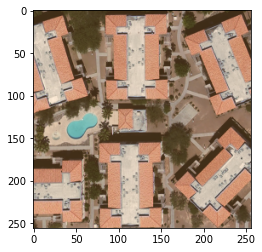

In [9]:
for i in range(50):
    img, label = next(data_viz)
plt.imshow(img.numpy()[0]) #Add 0.5 if it's zero-centered. (it's not quite 0.5 strictly but it's close enough)
print("Label: {}".format(label_dict[label.numpy()[0]]))
print(img.numpy()[0].mean())

In [10]:
data_numpy = np.stack([x[0] for x in list(data.as_numpy_iterator())]) #Could change this to not load whole dataset into memory if too big
labels = np.stack([x[1] for x in list(data.as_numpy_iterator())])

num_images = data_numpy.shape[0]
image_size = data_numpy.shape[1]
no_channels = data_numpy.shape[3]


In [29]:
%%time
scale_images = False
seed=0
svm_params = {'kernel':'linear', 'random_state':seed, 'C':1}

scene_embeddings = []

mean = data_numpy.mean(axis=0)
std = np.std(data_numpy, axis=0)

data_scaled = (data_numpy - mean)/std

for i in range(num_images):
    if scale_images:
        scene_embedding = np.array(model(data_scaled[i:i+1]))
    else:
        scene_embedding = np.array(model(data_numpy[i:i+1]))
        
    scene_embeddings.append(scene_embedding.flatten())
    
scene_embeddings = np.stack(scene_embeddings)

CPU times: user 43.8 s, sys: 448 ms, total: 44.2 s
Wall time: 44.1 s


In [30]:
X_train, X_test, y_train, y_test = train_test_split(scene_embeddings, labels, test_size=0.2, random_state=seed)

In [31]:
clf = make_pipeline(StandardScaler(), SVC(**svm_params))
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=1, kernel='linear', random_state=0))])

In [32]:
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

1.0
0.7233009708737864


In [33]:
f1_score(y_test, clf.predict(X_test), average=None)

array([0.607, 0.733, 0.5  , 0.636, 0.682, 0.902, 0.72 , 0.667, 0.645,
       0.622, 0.605, 0.629, 0.923, 0.894, 0.952, 1.   , 0.8  , 0.593,
       0.578, 0.737, 0.824])

Text(32.99999999999999, 0.5, 'True')

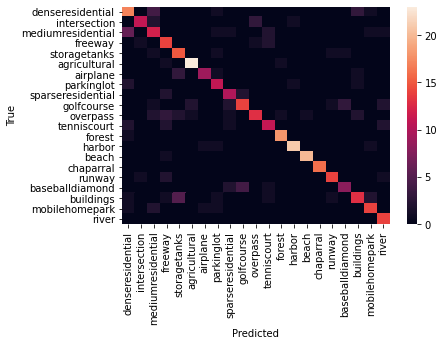

In [34]:
label_names = list(label_dict.values())

conf = confusion_matrix(y_test, clf.predict(X_test))

ax = plt.axes()
heatmap(conf, xticklabels=label_names, yticklabels=label_names, ax = ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')